# Chapter7. 集成学习——组合不同的模型
- 基于多数投票的预测
- 通过对训练数据集的重复抽样和随机组合降低模型的过拟合
- 通过弱学习机在误分类数据上的学习构建性能更好的模型

In [1]:
%matplotlib inline

## 1. 集成学习
基于训练集，我们首先训练$m$个不同的成员分类器（$C_1, \dot, C_m$）。在多数投票的原则下，可以集成不同的分类算法，如决策树、支持向量机、逻辑回归等。此外还可以使用相同的成员分类器训练不同的数据子集，如随机森林。

为了比较成员分类器在不同出错率情况下与集成分类器出错率的差异，我们用Python实现其概率密度函数：

In [2]:
# comb是计算组合函数的包
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    """
    计算集成分类器的错误率
    
    Parameters
    -----------
    n_classifier : 成员分类器的数量
    error : 单个成员分类器的误差
    """
    
    # ceil()函数返回数字的上入整数
    k_start = math.ceil(n_classifier / 2.0)
    # 计算二项分布
    probs = [comb(n_classifier, k) * error ** k * (1 - error) ** (n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [3]:
ensemble_error(n_classifier=11, error=0.25)

0.034327507019042969

可以看到，单个成员分类器错误率为0.25时，集成分类器的错误率为0.034，远小于单个分类器的错误率。

In [4]:
import numpy as np

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]

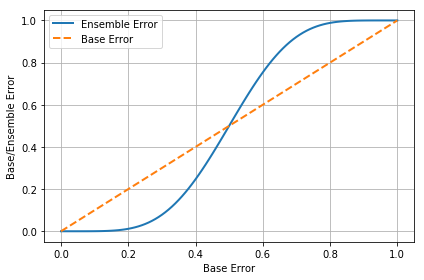

In [5]:
import matplotlib.pyplot as plt

plt.plot(error_range, ens_errors, label="Ensemble Error", linewidth=2)

plt.plot(error_range, error_range, label="Base Error",
         linestyle='--', linewidth=2)

plt.xlabel('Base Error')
plt.ylabel('Base/Ensemble Error')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

从图中看到，当单个成员分类器的错误率低于随机猜测（$\epsilon < 0.5$），集成分类器的错误率要低于单个分类器。

## 2. 实现一个简单的多数投票分类器
首先使用Python实现简单的加权多数投票，利用`argmax`和`bincount`实现

In [6]:
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

In [7]:
np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6])

array([ 0.4,  0.6])

这里给`bincount`方法加上了权重选项，就不是简单的统计出现次数，而是加权后的比重，例如：
```python
np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6])
```
这里就是$0\times 0.2 + 0 \times 0.2$和$1\times 0.6$

假定成员分类器$C_j$针对给定样本$x$做出如下预测：
$$C_1(x)\to[0.9, 0.1], C_2(x)\to[0.8, 0.2], C_3(x)\to[0.4, 0.6]$$
那么我们就可以按照如下方式计算所属类别的概率：
$$p(i_0|x)=0.2 \times 0.9 + 0.2 \times 0.8 + 0.6 \times 0.4 = 0.58 \\
  p(i_1|x)=0.2 \times 0.1 + 0.2 \times 0.2 + 0.6 \times 0.6 = 0.42$$
输出的类别就是：
$$\hat{y}=arg {max_j}[p(i_0|x), p(i_1|x)]=0$$

In [8]:
# ex可以看做三个成员分类器给出的概率预测。
ex = np.array([[0.9, 0.1],
               [0.8, 0.2], 
               [0.4, 0.6]])


p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([ 0.58,  0.42])

In [9]:
np.argmax(p)

0

In [10]:
# BaseEstimator是sklearn的基类
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """
    多数投票分类器
    
    Parameters
    -----------
    classifiers : array-like, shape = [n_classifiers]
        用于集成的成员分类器
    vote :        str, {'classlabel', 'probability'}(default='label')
        使用类标签的数量或者类标签的加权概率进行预测
    weights :     array-like, shape = [n_classifiers], optional (default=None)
        对成员分类器进行组合时使用的权重参数
        
    """
    def __init__(self, classifiers, vote='classlabel', weights=None):
        
        self.classifiers = classifiers
        # _name_estimator返回对应分类器的名字和参数设置，这里key就是分类器名称
        # value就是分类器的参数设置
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """
        拟合分类器
        
        Parameters
        -----------
        X : 训练数据集
        y : 类别标签
        
        Returns
        -----------
        self : 类
        
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote = %r)" % self.vote)
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError("Number of classifiers and weights must be equal"
                             "; got %d weights, %d classifiers"
                             % (len(self.weights), len(self.classifiers)))
            
        # 使用LabelEncoder来保证类标签从0开始，对下面的argmax方法输出类标很重要
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        # 根据classifiers中的分类器训练，并把结果放到self.classifiers_中
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """
        根据X预测类别
        
        Parameters
        -----------
        X : 训练数据集
        
        Returns
        -----------
        maj_vote : array-like, shape = [n_samples]
            预测的类别标签
            
        """
        if self.vote == 'probability':
            # 如果使用概率预测，直接返回概率最大的类别作为结果
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            # array和asarray都可以将结构数据转化为ndarray，
            # 但是主要区别就是当数据源是ndarray时，array仍然会copy出一个副本，
            # 占用新的内存，但asarray不会
            # 这里输出的是每个成员分类器的预测结果
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            # 沿行方向计算针对每个样本所有成员分类器的预测结果并取加权最大的那个
            maj_vote = np.apply_along_axis(lambda x: 
                                           np.argmax(np.bincount(x, 
                                                     weights=self.weights)),
                                           axis=1,
                                           arr=predictions)
        # 恢复原来的类别标签
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """
        预测X的类别概率
        
        Parameters
        -----------
        X : 训练数据集，单个向量
        
        Returns
        -----------
        avg_proba : 单个样本加权平均后每个类别的概率值
        
        """
        # 根据概率加权预测输出
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """
        在网格搜索时获取分类器参数
        
        """
        if not deep:
            # 使用super调用父类的方法，这里MajorityVoteClassifier是从
            # BaseEstimator, ClassifierMixin继承而来。
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            # six返回当前运行环境是否为Python3的一个boolean值
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

**基于多数投票原则组合不同的分类算法**

加载鸢尾花数据集，使用萼片宽度和花瓣长度作为输入特征，识别为Iris-Versicolor还是Iris-Virginica

In [11]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.5, random_state=1)

我们训练三种不同类型的分类器，LR， DecisionTree，kNN。在这之前先使用10折交叉验证看一下各个分类器的表现：

In [12]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2',
                          solver='liblinear',
                          C=0.001,
                          random_state=0)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])

pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


这里将逻辑回归和kNN作为流水线的一部分是因为他们对数据的缩放是敏感的，而决策树不敏感。现在我们来看一下集成后的分类器效果：

In [13]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]
ROC AUC: 0.97 (+/- 0.10) [Majority Voting]


可以看到集成后的分类器相对于单个的分类器性能有了显著提高。

## 3. 评估和调优集成分类器
本节在测试数据集上计算MajorityVoteClassifier的ROC曲线，验证其泛化性能。

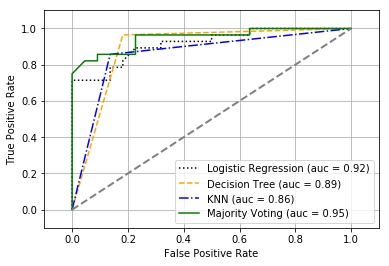

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # 假设正例的类标为1，所以输出predict_proba的第二列
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()                        

绘制决策边界

In [15]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

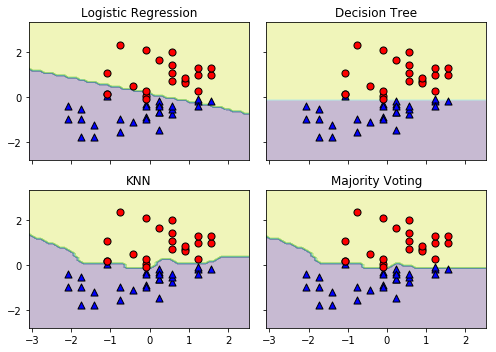

In [16]:
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  color='blue', 
                                  edgecolors='black', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  color='red', 
                                  edgecolors='black', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)
    
# plt.text(-3.5, -4.5, 
#          s='Sepal width [standardized]', 
#          ha='center', va='center', fontsize=12)
# plt.text(-10, 3, 
#          s='Petal length [standardized]', 
#          ha='center', va='center', 
#          fontsize=12, rotation=90)

plt.tight_layout()
plt.show()

In [17]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_impurity_split': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 

使用网格搜索调整超参数

In [18]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

cv_keys = ('mean_test_score', 'std_test_score', 'params')
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
              % (grid.cv_results_[cv_keys[0]][r], 
                 grid.cv_results_[cv_keys[1]][r] / 2.0, 
                 grid.cv_results_[cv_keys[2]][r]))

0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [19]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Accuracy: 1.00


## 4. bagging——通过bootstrap样本构建集成分类器
bagging使用有放回的随机抽样，对不同的成员分类器使用不同的训练子集。

In [20]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# 去除一个类别
df_wine = df_wine[df_wine['Class label'] != 1]

# 只是用两个特征
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

分割训练集

In [21]:
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.40, 
                             random_state=1)

使用未剪枝的决策树作为成员分类器

In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

分别计算在训练集和测试集上的准确率来比较两者的性能差异

In [23]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.833
Bagging train/test accuracies 1.000/0.896


可以看出两者分别有不同程度的过拟合现象，但是bag方法的泛化能力要稍强。

下面绘制两者的决策区域：

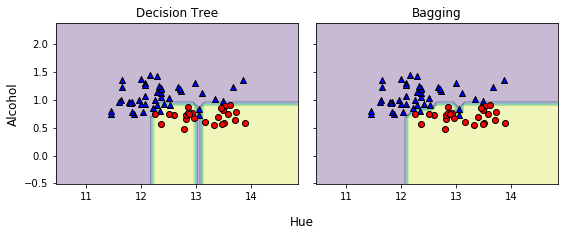

In [25]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       edgecolors='black', 
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       edgecolors='black', 
                       c='red', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2,
         s='Hue',
         ha='center', va='center', fontsize=12)

plt.tight_layout()

plt.show()

## 5. AdaBoost
原始的boosting方法：
1. 从训练集$D$中无放回抽样随机抽取一个训练子集$d_1$，用于弱学习机$C_1$的训练；
2. 从训练集中无放回抽样随机抽取第2个训练子集$d_2$，并将$C_1$中误分类样本的50%加入训练集，训练得到弱学习机$C_2$；
3. 从训练集$D$中抽取$C_1$和$C_2$分类结果不一致的样本生成训练集样本$d_3$，训练第三个弱学习机$C_3$；
4. 通过多数投票组合三个弱学习机$C_1$、$C_2$和$C_3$.

AdaBoost与原始的boosting方法不同，它使用整个训练集来训练弱学习机，每次迭代都会被重新赋予一个权重，在上一个弱学习机的基础上得到一个更强大的分类器。
1. 以等值方式为权重$\bf w$赋值，其中$\sum_iw_i=1$；
2. 在$m$轮boosting操作中，对第$j$轮进行如下操作：
3. 训练一个加权的弱学习机：$C_j = train(\bf X, y, w)$；
4. 预测训练样本类标$\hat y=predict(C_j, \bf X)$；
5. 计算权重错误率$\varepsilon = {\bf w} \cdot ({\bf \hat y} == {\bf y})$；
6. 计算相关系数：$\alpha_j=0.5log\frac{1-\varepsilon}{\varepsilon}$；
7. 更新权重：${\bf w}:= {\bf w} \times exp(-\alpha_j \times {\bf \hat y} \times {\bf y})$；
8. 归一化权重，使其和为1，${\bf w}:= {\bf w} / \sum_i{\bf w_i}$；
9. 完成最终预测：${\bf \hat y} = (\sum_{j=1}^{m}(\alpha_j \times predict(C_j, {\bf X})) > 0)$.

In [26]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=1,
                              random_state=0)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=0)

In [27]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 0.845/0.854
AdaBoost train/test accuracies 1.000/0.875


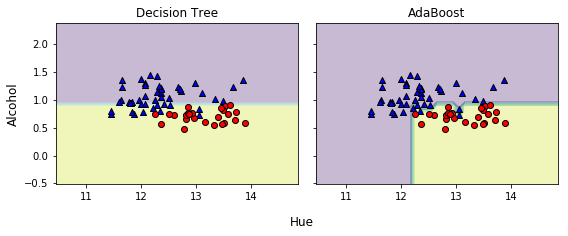

In [29]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       edgecolors='black', 
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       edgecolors='black', 
                       c='red', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2,
         s='Hue',
         ha='center', va='center', fontsize=12)

plt.tight_layout()
# plt.savefig('./figures/adaboost_region.png',
#           dpi=300,
#           bbox_inches='tight')
plt.show()